In [64]:
import numpy as np
from matplotlib import pyplot as plt
import uproot
import pandas as pd

import os
import xgboost as xgb

In [65]:
directory=os.getcwd()

In [66]:
algo_name={}
algo_name[0]='T23'
algo_name[1]='SDH'
algo_name[2]='SDH0'
algo_name[3]='SDH10'
algo_name[4]='SDH20'
algo_name[5]='TDH'
algo_name[6]='TDH0'
algo_name[7]='TDH10'
algo_name[8]='TDH20'

algo_e={}
algo_p={}
algo={}

In [67]:
path_elec='./electrons'
path_pions='./pions'

In [68]:

gen_e=pd.read_csv('./electrons/gen_clean.csv')
algo_e[0]=pd.read_csv('./electrons/T23.csv')
algo_e[1]=pd.read_csv('./electrons/SDH.csv')
algo_e[2]=pd.read_csv('./electrons/SDH0.csv')
algo_e[3]=pd.read_csv('./electrons/SDH10.csv')
algo_e[4]=pd.read_csv('./electrons/SDH20.csv')
algo_e[5]=pd.read_csv('./electrons/TDH.csv')
algo_e[6]=pd.read_csv('./electrons/TDH0.csv')
algo_e[7]=pd.read_csv('./electrons/TDH10.csv')
algo_e[8]=pd.read_csv('./electrons/TDH20.csv')
gen_p=pd.read_csv('./pions/gen_clean.csv')
algo_p[0]=pd.read_csv('./pions/T23.csv')
algo_p[1]=pd.read_csv('./pions/SDH.csv')
algo_p[2]=pd.read_csv('./pions/SDH0.csv')
algo_p[3]=pd.read_csv('./pions/SDH10.csv')
algo_p[4]=pd.read_csv('./pions/SDH20.csv')
algo_p[5]=pd.read_csv('./pions/TDH.csv')
algo_p[6]=pd.read_csv('./pions/TDH0.csv')
algo_p[7]=pd.read_csv('./pions/TDH10.csv')
algo_p[8]=pd.read_csv('./pions/TDH20.csv')

In [69]:
for i in algo_name:
    algo[i]=pd.concat([algo_e[i],algo_p[i]], sort=False)

In [70]:
#cut
ptcut=20
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo_name:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]

In [73]:
algo_cut[i].head()

,event,genpart_pid,genpart_exphi,genpart_exeta,genpart_gen,genpart_reachedEE,genpart_pt,genpart_energy,genpart_fbrem,cl3d_pt,...,cl3d_firstlayer,cl3d_maxlayer,cl3d_seetot,cl3d_spptot,cl3d_szz,cl3d_srrtot,deta,dphi,deltar,matches
0,90007,0,2.251530,-2.780936,1,2,92.377235,735.62994,0.065007,85.088770,...,1.0,13.0,0.024867,0.024764,4.892545,0.003119,-0.002222,0.000502,0.002278,True
1,90007,0,-0.885158,2.747410,2,2,92.377235,735.62994,0.626710,80.115560,...,1.0,13.0,0.025475,0.016632,5.509357,0.003297,-0.002867,0.007425,0.007959,True
2,90008,0,0.452241,1.715346,1,2,71.518640,206.79662,0.189231,74.406060,...,1.0,13.0,0.010371,0.010085,4.804339,0.004092,0.001322,0.001399,0.001925,True
3,90008,0,-2.670795,-1.731935,2,2,71.518640,206.79662,0.024179,73.915375,...,1.0,11.0,0.009281,0.010517,5.043524,0.003610,0.001107,0.001319,0.001722,True
4,90012,0,1.240060,-1.723961,2,2,52.553100,151.51414,0.020551,53.492250,...,1.0,11.0,0.010177,0.009027,4.588852,0.003955,-0.000083,0.000002,0.000083,True


In [72]:
for i in algo_name:
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

In [74]:
from sklearn.model_selection import train_test_split
columns=['cl3d_pt', 'cl3d_eta','cl3d_phi','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_szz', 'cl3d_srrtot']



i=1
X_train, X_test, y_train, y_test = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2, random_state=0)

In [75]:
train = xgb.DMatrix(data=X_train,label=y_train, feature_names=columns)
test = xgb.DMatrix(data=X_test,label=y_test,feature_names=columns)

In [76]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [77]:
%%time
booster = xgb.train(param,train,num_boost_round=num_trees)

Wall time: 3.58 s


In [78]:
booster.eval(test)

'[0]\teval-error:0.005604\teval-logloss:0.029568\teval-rmse:0.078492'

In [81]:
predictions=booster.predict(test)

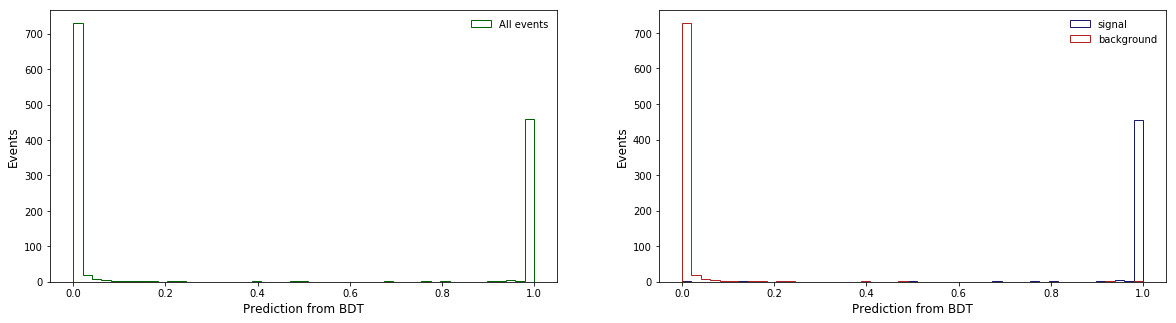

In [142]:
# plot all predictions (both signal and background)
plt.figure(figsize=(20,5));
plt.subplot(121);
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.subplot(122);
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

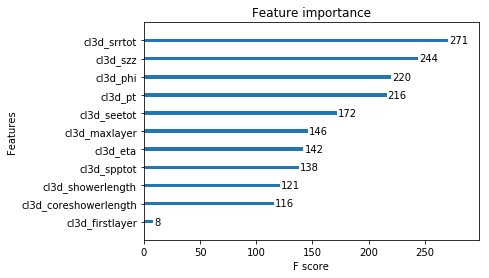

In [86]:
xgb.plot_importance(booster,grid=False);

In [134]:
def plot_discr(feature):
    nbins=20
    plt.hist(X_train[feature][y_train == 0],
         histtype='step',color='midnightblue',label='electron', bins=nbins);
    plt.hist(X_train[feature][y_train == 1],
         histtype='step',color='firebrick',label='pion', bins=nbins);
    plt.xlabel(feature,fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.legend(frameon=False);

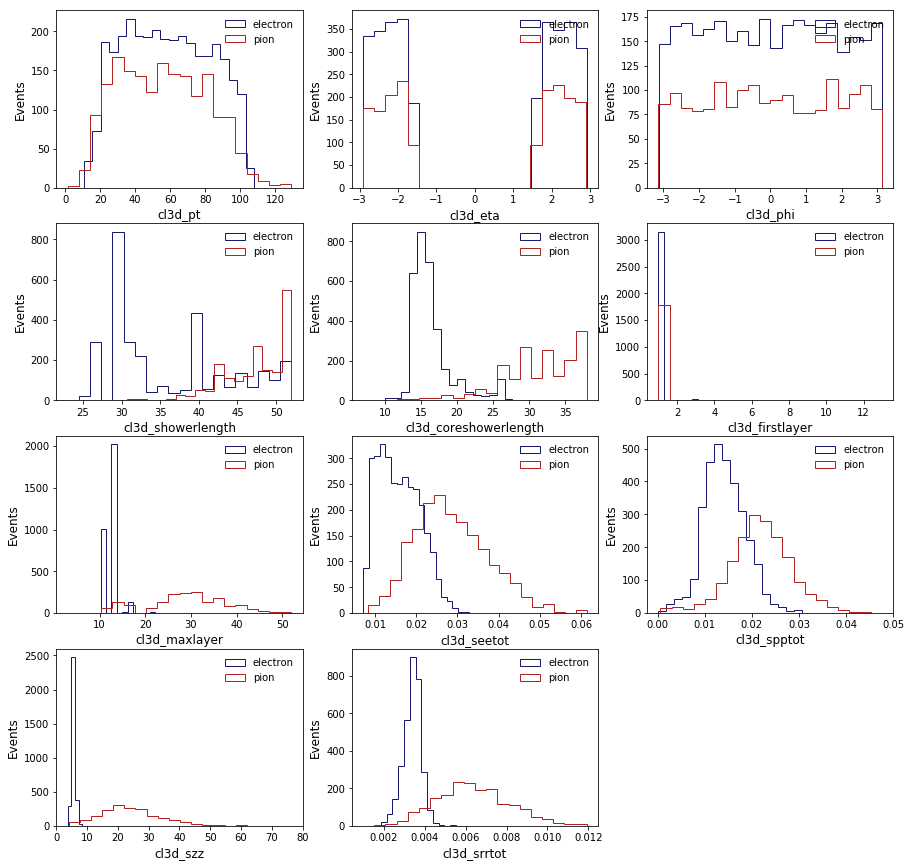

In [135]:
plt.figure(figsize=(15,15))
i=0
for feature in columns:
    i+=1
    plt.subplot(4,3,i)
    plot_discr(feature)


In [95]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

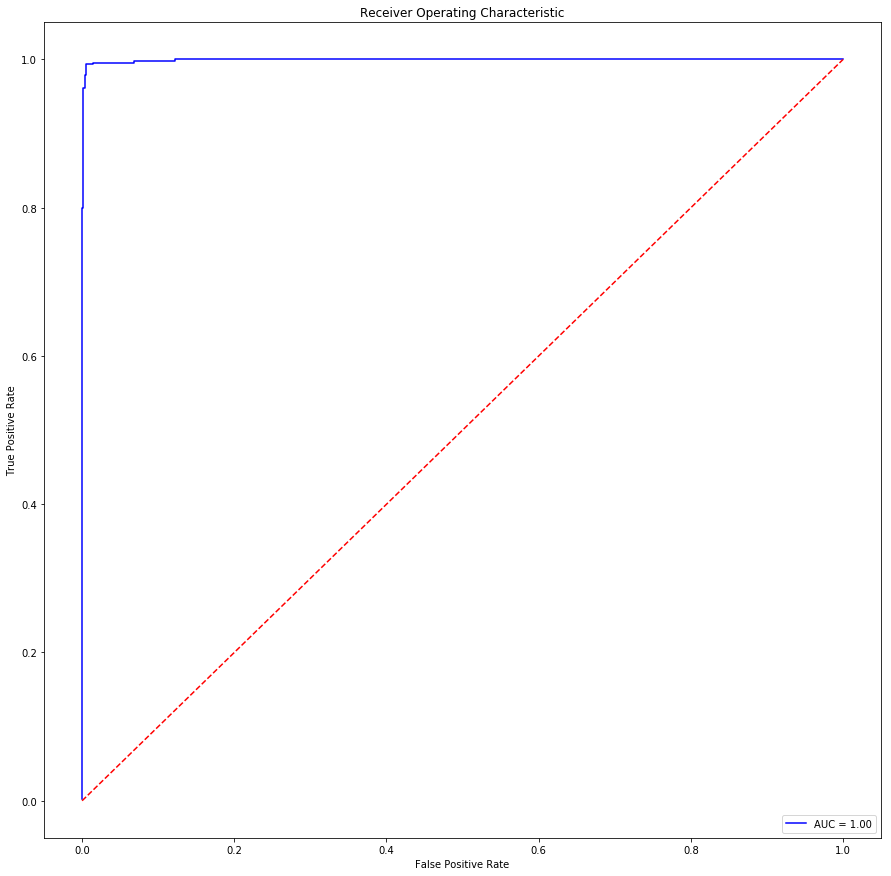

In [97]:
plt.figure(figsize=(15,15))
buildROC(y_test, predictions)